# 1. Parameters

In [1]:
simulation_dir <- "simulations"

simulation_dirs <- list.files(pattern='^(cov|alpha)', simulation_dir)

simulation_paths <- sapply(simulation_dirs, function(x){file.path(simulation_dir, x)})
simulation_read_trees <- sapply(simulation_paths, function(x){file.path(x, "index-reads", "reads.tre")})
simulation_assembly_trees <- sapply(simulation_paths, function(x){file.path(x, "index-assemblies", "assemblies.tre")})

names(simulation_read_trees) <- simulation_dirs
names(simulation_assembly_trees) <- simulation_dirs

initial_tree_file <- "input/salmonella.tre"
trees_table_file <- file.path(simulation_dir, "tree-comparisons.tsv")

In [2]:
simulation_read_trees

alpha-0.05-cov-30 
"simulations/alpha-0.05-cov-30/index-reads/reads.tre" 
                                     alpha-0.1-cov-30 
 "simulations/alpha-0.1-cov-30/index-reads/reads.tre" 
                                     alpha-0.5-cov-30 
 "simulations/alpha-0.5-cov-30/index-reads/reads.tre" 
                                     alpha-1.0-cov-30 
 "simulations/alpha-1.0-cov-30/index-reads/reads.tre" 
                                      alpha-10-cov-30 
  "simulations/alpha-10-cov-30/index-reads/reads.tre" 
                                     alpha-2.0-cov-30 
 "simulations/alpha-2.0-cov-30/index-reads/reads.tre" 
                                     alpha-5.0-cov-30 
 "simulations/alpha-5.0-cov-30/index-reads/reads.tre" 
                                               cov-10 
           "simulations/cov-10/index-reads/reads.tre" 
                                               cov-20 
           "simulations/cov-20/index-reads/reads.tre" 
                                               cov-30 
           "simulations/cov-30/index-reads/reads.tre" 
                                               cov-40 
           "simulations/cov-40/index-reads/reads.tre" 
                                                cov-5 
            "simulations/cov-5/index-reads/reads.tre" 
                                               cov-50 
           "simulations/cov-50/index-reads/reads.tre"

In [3]:
simulation_assembly_trees

alpha-0.05-cov-30 
"simulations/alpha-0.05-cov-30/index-assemblies/assemblies.tre" 
                                               alpha-0.1-cov-30 
 "simulations/alpha-0.1-cov-30/index-assemblies/assemblies.tre" 
                                               alpha-0.5-cov-30 
 "simulations/alpha-0.5-cov-30/index-assemblies/assemblies.tre" 
                                               alpha-1.0-cov-30 
 "simulations/alpha-1.0-cov-30/index-assemblies/assemblies.tre" 
                                                alpha-10-cov-30 
  "simulations/alpha-10-cov-30/index-assemblies/assemblies.tre" 
                                               alpha-2.0-cov-30 
 "simulations/alpha-2.0-cov-30/index-assemblies/assemblies.tre" 
                                               alpha-5.0-cov-30 
 "simulations/alpha-5.0-cov-30/index-assemblies/assemblies.tre" 
                                                         cov-10 
           "simulations/cov-10/index-assemblies/assemblies.tre" 
                                                         cov-20 
           "simulations/cov-20/index-assemblies/assemblies.tre" 
                                                         cov-30 
           "simulations/cov-30/index-assemblies/assemblies.tre" 
                                                         cov-40 
           "simulations/cov-40/index-assemblies/assemblies.tre" 
                                                          cov-5 
            "simulations/cov-5/index-assemblies/assemblies.tre" 
                                                         cov-50 
           "simulations/cov-50/index-assemblies/assemblies.tre"

# 2. Compare trees

## 2.1. Load trees

In [4]:
library(ape)

read_and_root_tree <- function(file, keep.multi) {
    if (file.info(file)$size > 0) {
        tree <- ape::read.tree(file=file, keep.multi=keep.multi)
        tree <- ape::root(tree, "reference", resolve.root=TRUE)
    } else {
        tree <- NULL
    }
    
    return(tree)
}

t_orig <- read_and_root_tree(file=initial_tree_file, keep.multi=FALSE)

t_reads <- lapply(simulation_read_trees, function(x){read_and_root_tree(file=x, keep.multi=TRUE)})
t_reads <- do.call(c, unlist(t_reads, recursive=FALSE))
t_assemblies <- lapply(simulation_assembly_trees, function(x){read_and_root_tree(file=x, keep.multi=TRUE)})
t_assemblies <- do.call(c, unlist(t_assemblies, recursive=FALSE))

## 2.2. Distances between trees

In [5]:
library(treespace)

reference_other_distances <- function(reference_tree, other_trees, dist_func) {
    distances <- c()
    labels <- names(other_trees)
    for(label in labels) {
        tree <- other_trees[[label]]
        distance <- dist_func(reference_tree, tree, normalize=TRUE, rooted=TRUE)
        distances <- c(distances, distance)
    }
    
    return(distances)
}

tree_distances_reference <- function(reference_tree, read_trees, assembly_trees) {
    types <- c(rep("reads", each=length(read_trees)), rep("assembly", each=length(assembly_trees)))
    labels <- c(names(read_trees), names(assembly_trees))
    lambda <- 0.5
    distances = c(treespace::refTreeDist(reference_tree, read_trees, lambda=lambda),
                 treespace::refTreeDist(reference_tree, assembly_trees, lambda=lambda))
    
    rfn_distance_reads <- reference_other_distances(t_orig, read_trees, phangorn::RF.dist)
    rfn_distance_assemblies <- reference_other_distances(t_orig, assembly_trees, phangorn::RF.dist)
    rfn_distances <- c(rfn_distance_reads, rfn_distance_assemblies)
    
    wrfn_distance_reads <- reference_other_distances(t_orig, read_trees, phangorn::wRF.dist)
    wrfn_distance_assemblies <- reference_other_distances(t_orig, assembly_trees, phangorn::wRF.dist)
    wrfn_distances <- c(rfn_distance_reads, rfn_distance_assemblies)
    
    df <- data.frame(
               Type = types,
               Simulation = labels,
               RFN_Distance = rfn_distances,
               wRFN_Distance = wrfn_distances,
               KC_Distance = distances)
    
    return(df)
}

tree_distances_df <- tree_distances_reference(t_orig, t_reads, t_assemblies)
# tree_distances_df["Coverage"] <- as.numeric(tree_distances_df$Coverage)
tree_distances_df

Loading required package: ade4

Creating a generic function for ‘toJSON’ from package ‘jsonlite’ in package ‘googleVis’

Registered S3 methods overwritten by 'adegraphics':
  method         from
  biplot.dudi    ade4
  kplot.foucart  ade4
  kplot.mcoa     ade4
  kplot.mfa      ade4
  kplot.pta      ade4
  kplot.sepan    ade4
  kplot.statis   ade4
  scatter.coa    ade4
  scatter.dudi   ade4
  scatter.nipals ade4
  scatter.pco    ade4
  score.acm      ade4
  score.mix      ade4
  score.pca      ade4
  screeplot.dudi ade4

code for methods in class “Rcpp_Fitch” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_Fitch” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)



Type,Simulation,RFN_Distance,wRFN_Distance,KC_Distance
<chr>,<chr>,<dbl>,<dbl>,<dbl>
reads,alpha-0.05-cov-30,0.7413793,0.7413793,76.19291
reads,alpha-0.1-cov-30,0.7586207,0.7586207,87.62122
reads,alpha-0.5-cov-30,0.7241379,0.7241379,92.97345
reads,alpha-1.0-cov-30,0.7413793,0.7413793,81.64737
reads,alpha-2.0-cov-30,0.7413793,0.7413793,83.06765
reads,alpha-5.0-cov-30,0.7413793,0.7413793,81.50576
reads,cov-10,0.7931034,0.7931034,90.90671
reads,cov-20,0.7241379,0.7241379,79.29607
reads,cov-30,0.7413793,0.7413793,71.78496


In [6]:
write.table(tree_distances_df, trees_table_file, append = FALSE, sep = "\t", dec = ".",
            row.names = FALSE, col.names = TRUE)

# 3. Visualize trees

## 3.1. Reads

In [7]:
names(t_reads)

[1] "alpha-0.05-cov-30" "alpha-0.1-cov-30"  "alpha-0.5-cov-30" 
 [4] "alpha-1.0-cov-30"  "alpha-2.0-cov-30"  "alpha-5.0-cov-30" 
 [7] "cov-10"            "cov-20"            "cov-30"           
[10] "cov-40"            "cov-5"             "cov-50"

### 3.1.1. (Best Coverage) Transition rate=0.2, coverage=20X

Loading required package: maps



Rotating nodes to optimize matching...
Done.


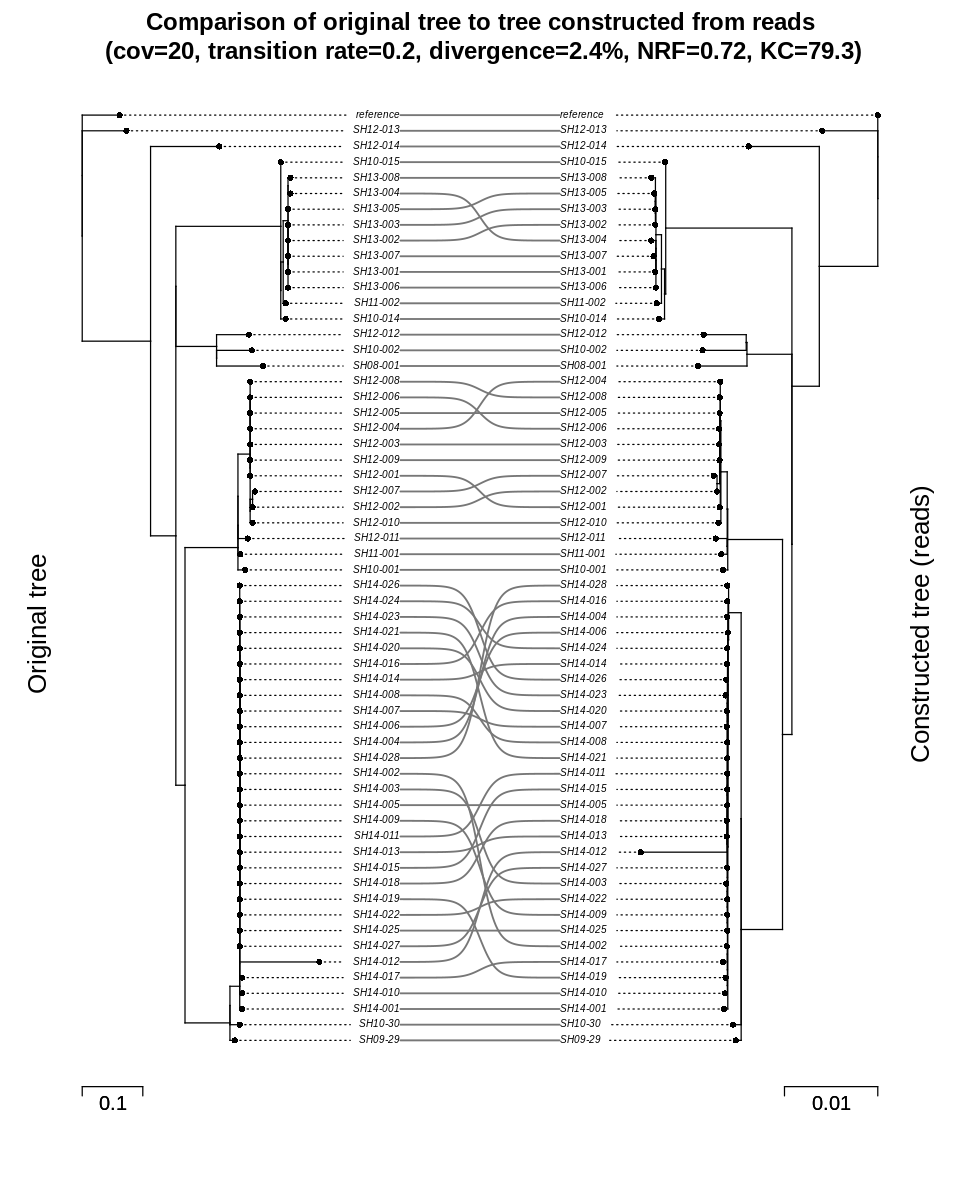

In [8]:
library(phytools)

printf <- function(...) invisible(print(sprintf(...)))

plot_tree <- function(simulation, label, data_type, trees_array, file) {
    if (is.null(trees_array[[simulation]])) {
        printf("Tree for simulation=%s, data_type=%s is null", simulation, data_type)
    } else {
        rfn_distance <- tree_distances_df[tree_distances_df["Simulation"] == simulation & tree_distances_df["Type"] == data_type, "RFN_Distance"]
        kc_distance <- tree_distances_df[tree_distances_df["Simulation"] == simulation & tree_distances_df["Type"] == data_type, "KC_Distance"]

        if (!is.null(file)) {
            pdf(file = file)
        }

        options(repr.plot.width=8, repr.plot.height=10)
        par(mar = c(1,1,5,1), oma=c(1,2,3,2))
        plot(phytools::cophylo(t_orig, trees_array[[simulation]], rotate=TRUE),
             fsize=0.5, scale.bar=c(0.1,0.01),
             link.type="curved", link.col="#777777", link.lwd=1.5, link.lty=1)
        title(main=sprintf("Comparison of original tree to tree constructed from %s\n (%s, NRF=%0.2f, KC=%0.1f)",
                           data_type, label, rfn_distance, kc_distance), outer=TRUE)
        mtext("Original tree", side=2, cex=1.3)
        mtext(sprintf("Constructed tree (%s)", data_type), side=4, cex=1.3)
    }
}

plot_tree(simulation="cov-20", label=sprintf("cov=20, transition rate=0.2, divergence=2.4%%"),
          data_type="reads", trees_array=t_reads,
          file=NULL)

In [9]:
plot_tree(simulation="cov-20", label=sprintf("cov=20, transition rate=0.2, divergence=2.4%%"),
          data_type="reads", trees_array=t_reads,
          file="figures/original-reads-tree-cov-20-alpha-0.2.pdf")
dev.off()

Rotating nodes to optimize matching...
Done.


png 
  2

### 3.1.2. (Worst Coverage) Coverage=5, transition rate=0.2

Rotating nodes to optimize matching...
Done.


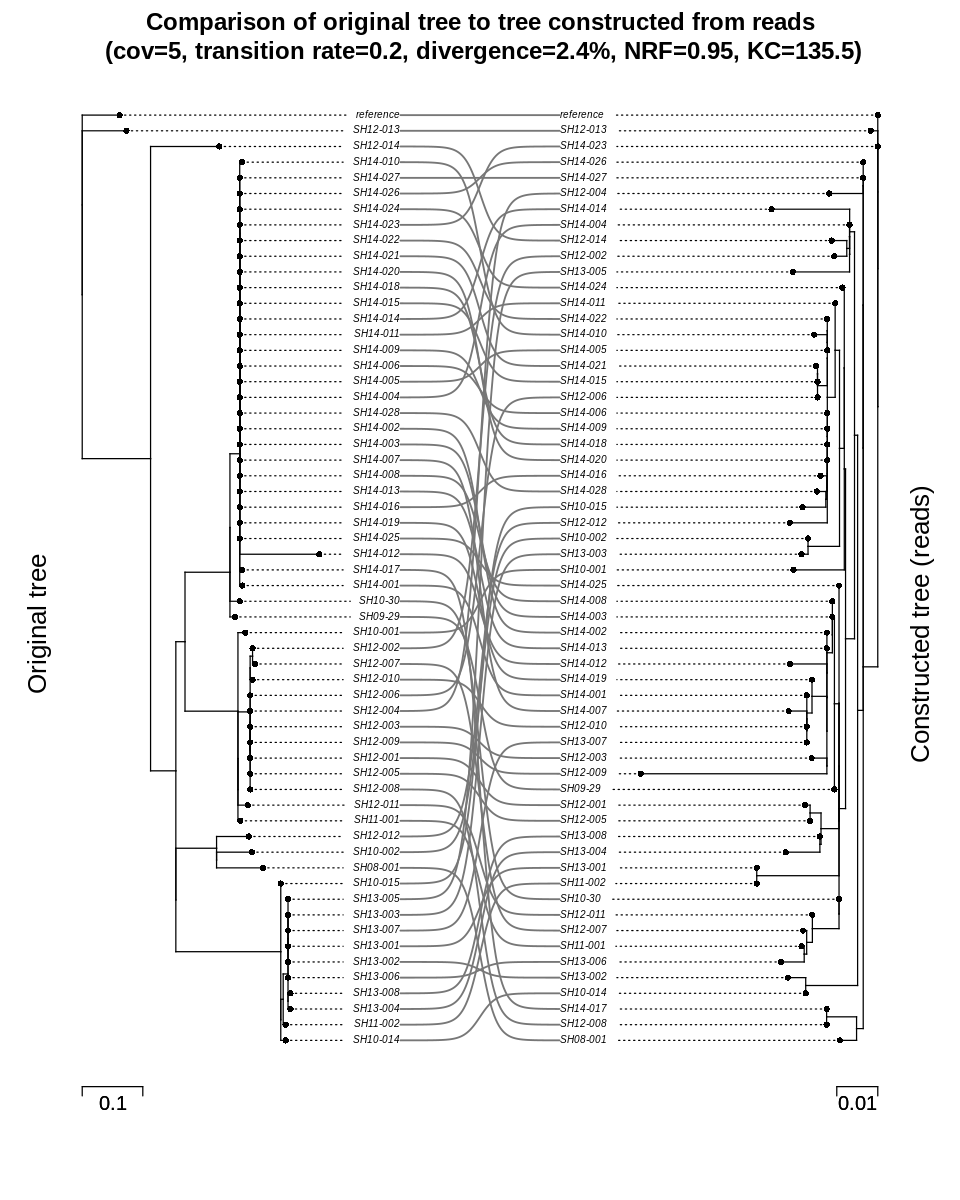

In [10]:
plot_tree(simulation="cov-5", label=sprintf("cov=5, transition rate=0.2, divergence=2.4%%"),
          data_type="reads", trees_array=t_reads,
          file=NULL)

In [11]:
plot_tree(simulation="cov-5", label=sprintf("cov=5, transition rate=0.2, divergence=2.4%%"),
          data_type="reads", trees_array=t_reads,
          file="figures/original-reads-tree-cov-5-alpha-0.2.pdf")
dev.off()

Rotating nodes to optimize matching...
Done.


png 
  2

### 3.1.3. (Best NRF Transition rate reads) Tranition rate=0.5

Rotating nodes to optimize matching...
Done.


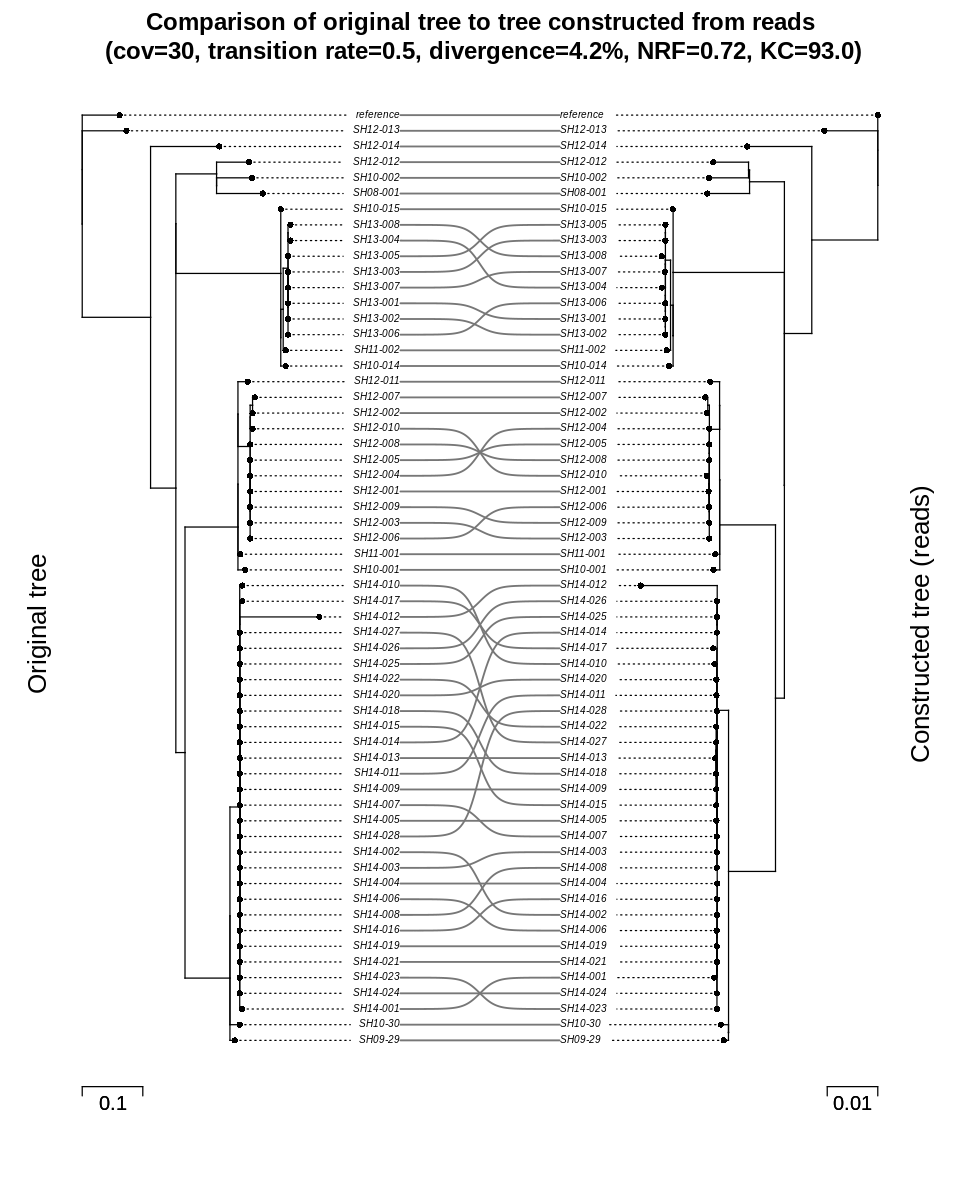

In [12]:
plot_tree(simulation="alpha-0.5-cov-30", label=sprintf("cov=30, transition rate=0.5, divergence=4.2%%"),
          data_type="reads", trees_array=t_reads,
          file=NULL)

In [13]:
plot_tree(simulation="alpha-0.5-cov-30", label=sprintf("cov=30, transition rate=0.5, divergence=4.2%%"),
          data_type="reads", trees_array=t_reads,
          file="figures/original-reads-tree-cov-30-alpha-0.5.pdf")
dev.off()

Rotating nodes to optimize matching...
Done.


png 
  2

### 3.1.4. (Best NRF Transition rate assembly) Tranition rate=0.1

Rotating nodes to optimize matching...
Done.


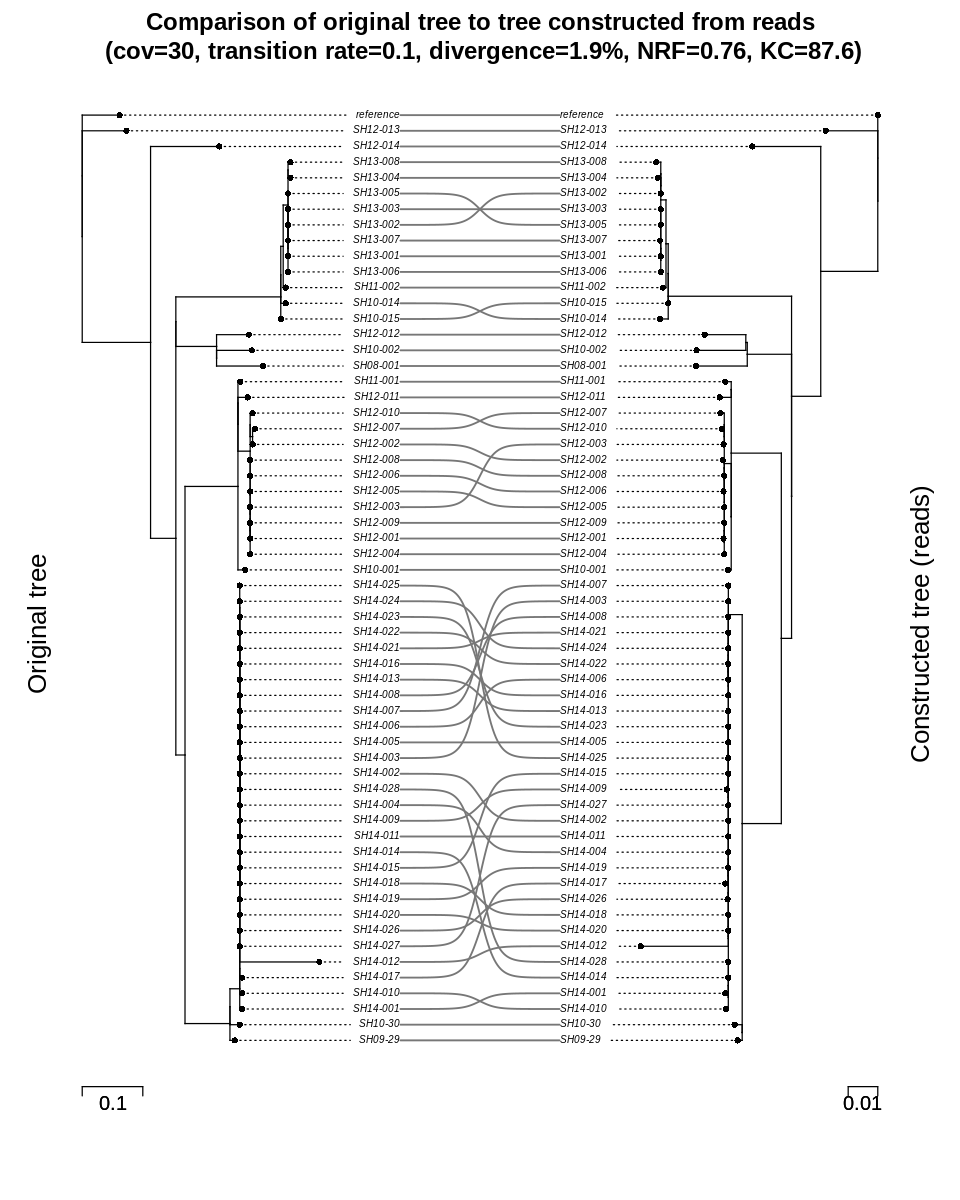

In [14]:
plot_tree(simulation="alpha-0.1-cov-30", label=sprintf("cov=30, transition rate=0.1, divergence=1.9%%"),
          data_type="reads", trees_array=t_reads,
          file=NULL)

In [15]:
plot_tree(simulation="alpha-0.1-cov-30", label=sprintf("cov=30, transition rate=0.1, divergence=1.9%%"),
          data_type="reads", trees_array=t_reads,
          file="figures/original-reads-tree-cov-30-alpha-0.1.pdf")
dev.off()

Rotating nodes to optimize matching...
Done.


png 
  2

## 3.2. Assemblies

### 3.2.1. (Best Coverage NRF TR=0.2) Transition rate=0.2, coverage=20

Rotating nodes to optimize matching...
Done.


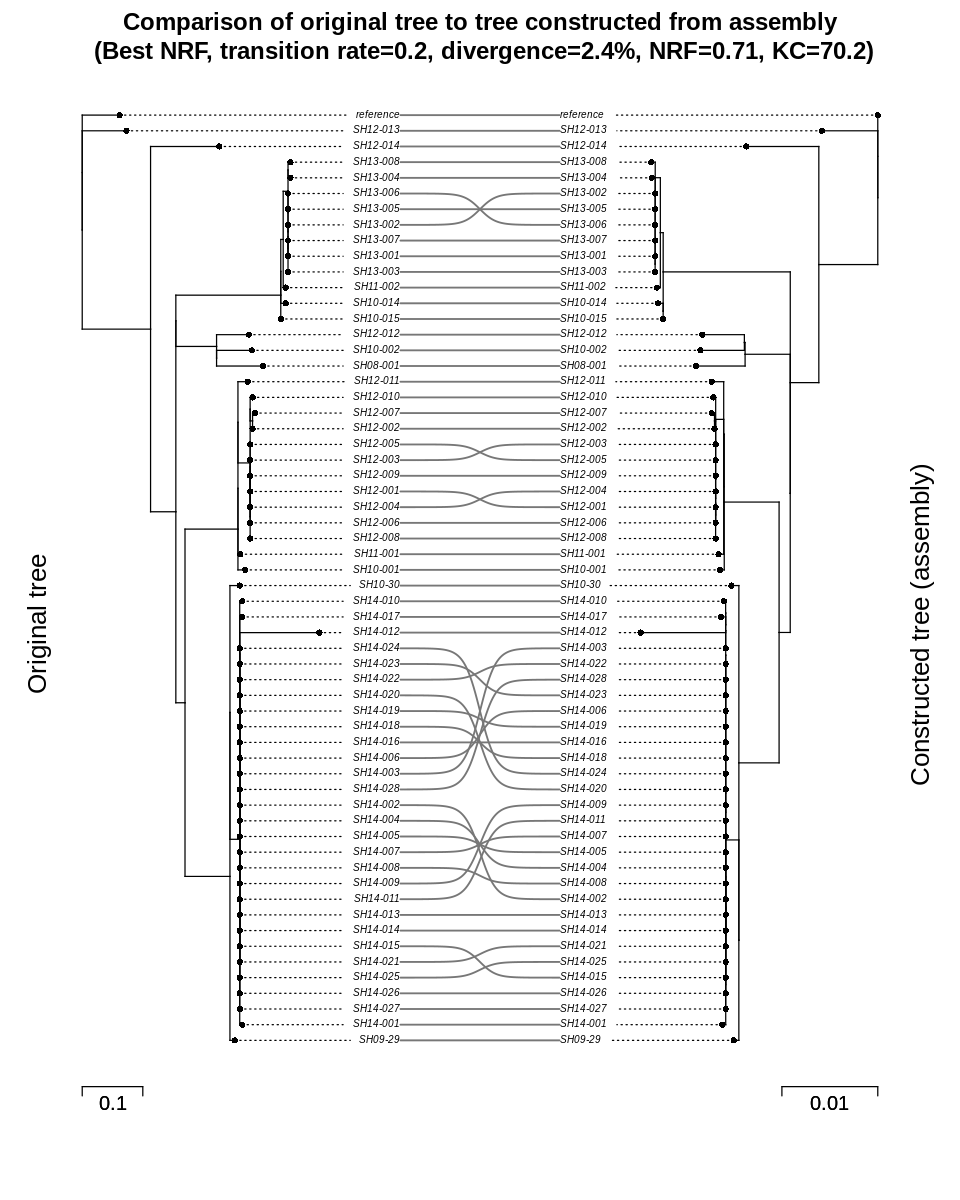

In [16]:
plot_tree(simulation="cov-20", label=sprintf("Best NRF, transition rate=0.2, divergence=2.4%%"),
          data_type="assembly", trees_array=t_assemblies,
          file=NULL)

In [17]:
plot_tree(simulation="cov-20", label=sprintf("Best NRF, transition rate=0.2, divergence=2.4%%"),
          data_type="assembly", trees_array=t_assemblies,
          file="figures/original-assemblies-tree-alpha-0.2-cov-20.pdf")
dev.off()

Rotating nodes to optimize matching...
Done.


png 
  2

### 3.2.2. (Best NRF Transition rate assembly) Transition rate=0.1

Rotating nodes to optimize matching...
Done.


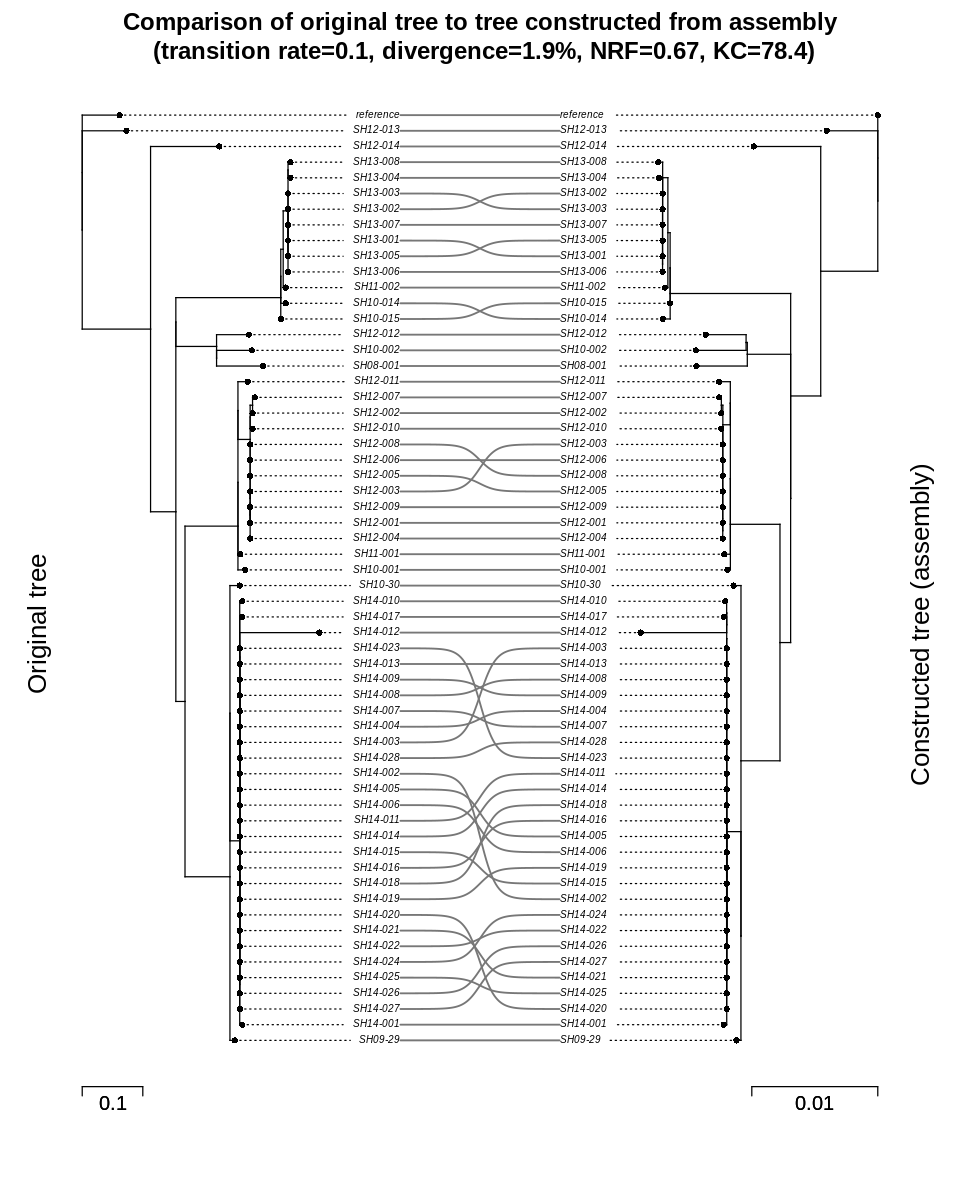

In [18]:
plot_tree(simulation="alpha-0.1-cov-30", label=sprintf("transition rate=0.1, divergence=1.9%%"),
          data_type="assembly", trees_array=t_assemblies,
          file=NULL)

In [19]:
plot_tree(simulation="alpha-0.1-cov-30", label=sprintf("transition rate=0.1, divergence=1.9%%"),
          data_type="assembly", trees_array=t_assemblies,
          file="figures/original-assemblies-tree-alpha-0.1.pdf")
dev.off()

Rotating nodes to optimize matching...
Done.


png 
  2

### 3.2.3. (Best NRF Transition rate reads) Transition rate=0.5

Rotating nodes to optimize matching...
Done.


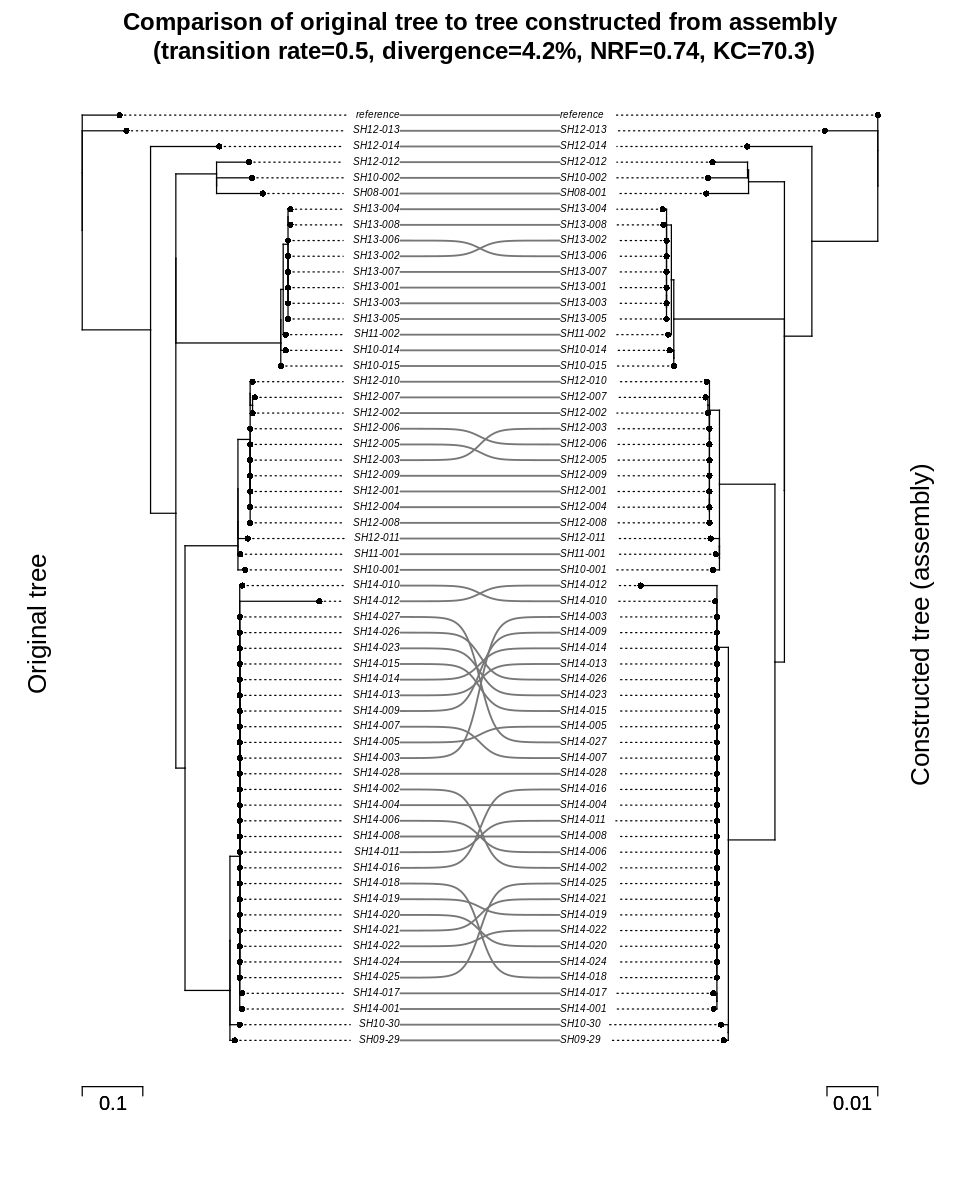

In [20]:
plot_tree(simulation="alpha-0.5-cov-30", label=sprintf("transition rate=0.5, divergence=4.2%%"),
          data_type="assembly", trees_array=t_assemblies,
          file=NULL)

In [21]:
plot_tree(simulation="alpha-0.5-cov-30", label=sprintf("transition rate=0.5, divergence=4.2%%"),
          data_type="assembly", trees_array=t_assemblies,
          file="figures/original-assemblies-tree-alpha-0.5.pdf")
dev.off()

Rotating nodes to optimize matching...
Done.


png 
  2